# 1. Loading libraries and Pre-Processing

### Loading libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_recall_curve,auc,roc_auc_score,recall_score,classification_report,mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import warnings
warnings.filterwarnings('ignore')
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import seaborn as sns
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


### Loading training and test data sets

In [10]:
df_train = pd.read_csv('./data/aps_failure_training_set.csv', na_values = 'na')
df_test = pd.read_csv('./data/aps_failure_test_set.csv', na_values = 'na')

### Data exploration: feature types and counting positive and negative instances

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB


In [4]:
df_train['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

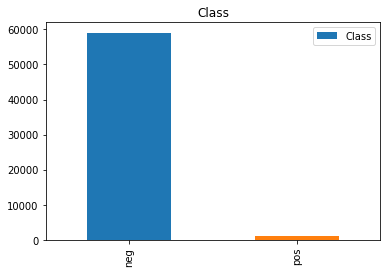

In [5]:
df_train['class'].value_counts().plot(kind='bar', label='Class')
plt.legend()
plt.title('Class');

### Checking if there are missing values

In [8]:
df_train.isnull().sum()

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
ae_000     2500
af_000     2500
ag_000      671
ag_001      671
ag_002      671
ag_003      671
ag_004      671
ag_005      671
ag_006      671
ag_007      671
ag_008      671
ag_009      671
ah_000      645
ai_000      629
aj_000      629
ak_000     4400
al_000      642
am_0        629
an_000      642
ao_000      589
ap_000      642
aq_000      589
ar_000     2723
as_000      629
at_000      629
          ...  
dl_000     4008
dm_000     4009
dn_000      691
do_000     2724
dp_000     2726
dq_000     2726
dr_000     2726
ds_000     2727
dt_000     2727
du_000     2726
dv_000     2726
dx_000     2723
dy_000     2724
dz_000     2723
ea_000     2723
eb_000     4007
ec_00     10239
ed_000     9553
ee_000      671
ee_001      671
ee_002      671
ee_003      671
ee_004      671
ee_005      671
ee_006      671
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int6

### Pre-processing data (converting text 'pos'/'neg' values to 1/0)

In [11]:
df_train['class'].replace('pos', 1, inplace = True)
df_train['class'].replace('neg', 0, inplace = True)
df_test['class'].replace('pos', 1, inplace = True)
df_test['class'].replace('neg', 0, inplace = True)

### Plotting correlation matrix

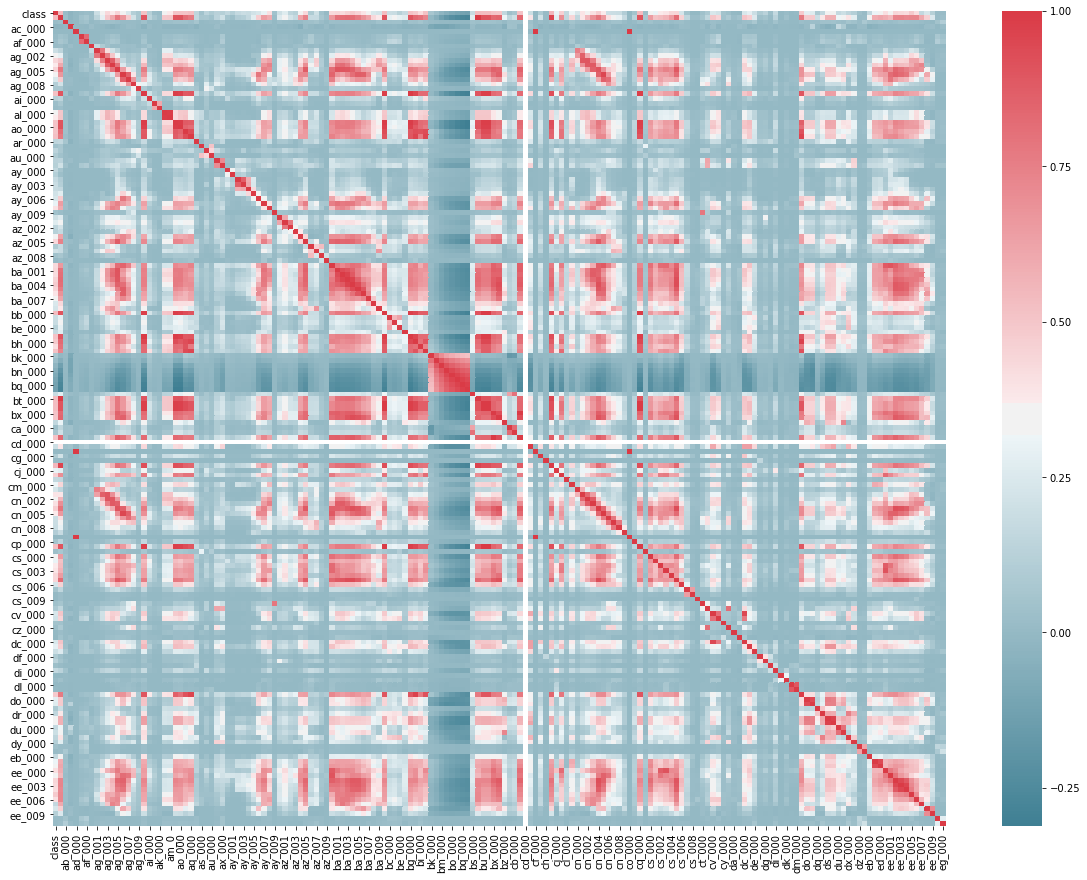

In [132]:
corr_matrix = df_train.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix, cmap = sns.diverging_palette(220, 10, as_cmap=True))

#### Correlation matrix is hard to read, when has large number of features, at this point we are not going to drop any features

### Pre-processing data (filling 'na' values with mean values, splitting both to datasets into features and class dataframes)

In [12]:
df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_test.mean())

In [13]:
X_test = df_test.drop(['class'], axis=1)
y_test = df_test['class']
X_train = df_train.drop(['class'], axis=1)
y_train = df_train['class']

# 2. Experimenting with feature selection and scaling the data

### Trying two methods: selection of k best features (k = 140 gives the best result) and variance threshold = 0.9

In [14]:
selector = SelectKBest(f_classif, k=140)
X_train_kbest = selector.fit_transform(X_train, y_train)
X_train_varth = VarianceThreshold(.9).fit_transform(X_train)

In [19]:
start = time.time()
print('Recall (no feature selection):', cross_val_score(LogisticRegression(C=1, n_jobs=-1, class_weight='balanced', random_state=20), X_train, y_train, scoring='recall').mean())
end = time.time()
print('Time (no feature selection):', end-start)
start = time.time()
print('Recall (univariate feature selection, k=140):', cross_val_score(LogisticRegression(C=1, n_jobs=-1, class_weight='balanced', random_state=20), X_train_kbest, y_train, scoring='recall').mean())
end = time.time()
print('Time (univariate feature selection, k=140):', end-start)
start = time.time()
print('Recall (variance threshold=0.9):', cross_val_score(LogisticRegression(C=1, n_jobs=-1, class_weight='balanced', random_state=20), X_train_varth, y_train, scoring='recall').mean())
end = time.time()
print('Time (variance threshold=0.9):', end-start)

Recall (no feature selection): 0.9119898341455229
Time (no feature selection): 65.0358304977417
Recall (univariate feature selection, k=140): 0.9049888211564858
Time (univariate feature selection, k=140): 70.63309979438782
Recall (variance threshold=0.9): 0.9019858181534829
Time (variance threshold=0.9): 85.3065938949585


### Since there is no improvement in recall score with Logistic Regression, we are not going to use feature selection. We assume that other methods (Decision Tree, Random Forest and SVM), which are more complex than Logistic Regression, would not benefit from feature selection as well, since it does not improve results for such simple method as Linear Regression.

### Scaling values to get rid of big numbers in order to make training faster

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 3. Applying different machine learning algorithms

## 3.1. Logistic Regression

### Baseline

In [223]:
C = 1
lr = LogisticRegression(C=C, penalty='l2', n_jobs=-1, class_weight='balanced', random_state=20)
lr.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=20,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Recall Score: 92.80%
Total Costs:  17390


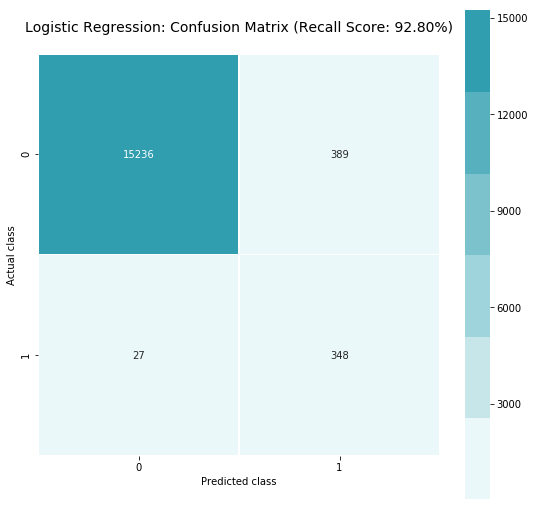

In [224]:
y_pred = lr.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'Logistic Regression: Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

### Choosing best regularization parameter C using K-Fold cross-validation with the following parameters: number of cross-validations = 5, balanced class weithing (because the dataset is unbalanced), recall as scoring function (because our goal is to minimize the number of FN, since they are very expensive) and fitting the model

In [225]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

lr_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=10, n_jobs=-1, scoring='recall', class_weight='balanced')
lr_searcher.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.0s remaining:   40.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   28.9s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.8s finished


Wall time: 37.6 s


### Best parameter found by LogisticRegressionCV optimizer:

In [226]:
lr_searcher.C_

array([0.001])

### Applying the model to the test set, measuring recall and printing confusion matrix

Recall Score: 94.13%
Total Costs:  14840


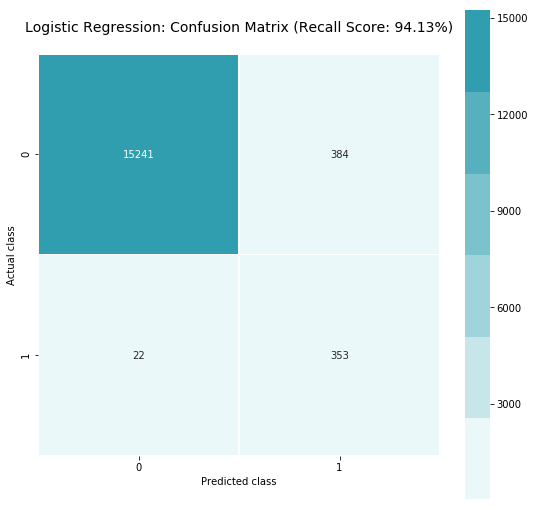

In [227]:
y_pred = lr_searcher.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'Logistic Regression: Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

### Printing cross-validation graphs

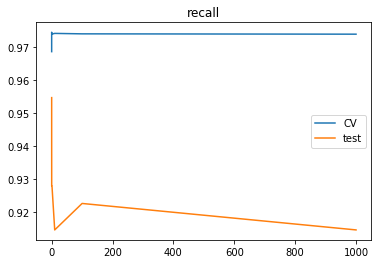

In [93]:
cv_scores, test_scores = [], []
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for c in c_values:

    lr = LogisticRegression(C=c, penalty='l2', n_jobs=-1, class_weight='balanced', random_state=20)
    cv_scores.append(np.mean(cross_val_score(lr, X_train, y_train, cv=5)))
    lr.fit(X_train, y_train)
    test_scores.append(recall_score(y_test, lr.predict(X_test)))

plt.plot(c_values, cv_scores, label='CV')
plt.plot(c_values, test_scores, label='test')
plt.title('recall')
plt.legend();

### Looks like it makes sense to check smaller C values. With C = 0.0001 CV score is lower, but test score is the highest

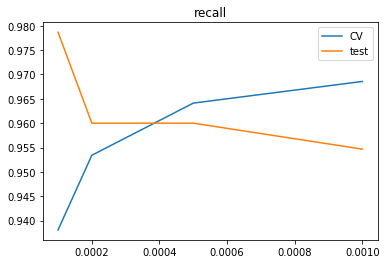

In [111]:
cv_scores, test_scores = [], []
c_values = [0.0001, 0.0002, 0.0005, 0.001]

for c in c_values:

    lr = LogisticRegression(C=c, penalty='l2', n_jobs=-1, class_weight='balanced', random_state=20)
    cv_scores.append(np.mean(cross_val_score(lr, X_train, y_train, cv=5)))
    lr.fit(X_train, y_train)
    test_scores.append(recall_score(y_test, lr.predict(X_test)))

plt.plot(c_values, cv_scores, label='CV')
plt.plot(c_values, test_scores, label='test')
plt.title('recall')
plt.legend();

### Applying the model with C = 0.0001 to the test set, measuring recall and printing confusion matrix

Recall Score: 97.87%
Total Costs:  12460


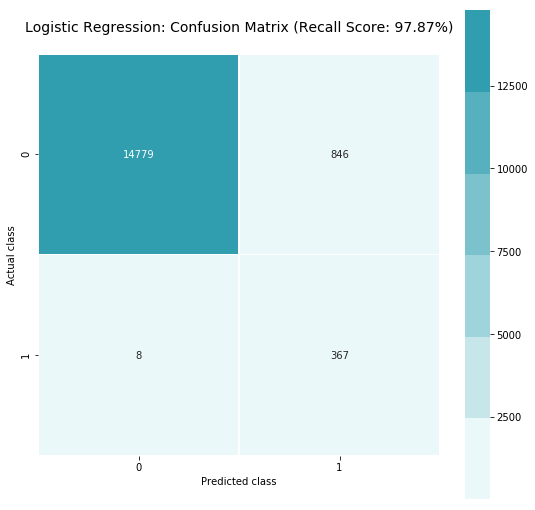

In [228]:
lr = LogisticRegression(C=0.0001, penalty='l2', n_jobs=-1, class_weight='balanced', random_state=20)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'Logistic Regression: Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

## 3.2. Decision Tree

### Baseline

In [39]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
tree = DecisionTreeClassifier(random_state=20, max_depth=20, criterion='gini')
results = cross_val_score(tree, X_train, y_train, cv=skf, scoring='recall')
print("CV recall score: {:.2f}%".format(results.mean()*100))

CV recall score: 67.70%


### Choosing best parameters using Grid Search crossvalidation. Tuned parameters: max_depth - maximal depth of the tree, max_features - number of features to consider when looking for best split, min_samples_leaf - minimal number of instances that have to be in a leaf node, criterion - entropy or gini. Still using 5 crossvalidations, balanced class weithing and recall as scoring function.

In [41]:
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, None], 'max_features': ['sqrt', 'log2', 20, 30, 50, 100, 150, 170, None], 'class_weight': ['balanced'], 'min_samples_leaf': [1, 3, 5], 'criterion': ['entropy', 'gini']}
gcv = GridSearchCV(tree, parameters, n_jobs=-1, cv=skf, verbose=10, scoring='recall')
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.7s
[Paralle

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, None], 'max_features': ['sqrt', 'log2', 20, 30, 50, 100, 150, 170, None], 'class_weight': ['balanced'], 'min_samples_leaf': [1, 3, 5], 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=10)

### The best parameters are:

In [42]:
gcv.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

### Applying the model to the test set, measuring recall, printing confusion matrix and total cost:

In [47]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
tree = DecisionTreeClassifier(random_state=20, max_depth=3, max_features='sqrt', min_samples_leaf=1, class_weight='balanced', criterion='entropy')
results = cross_val_score(tree, X_train, y_train, cv=skf, scoring='recall')
print("CV recall score: {:.2f}%".format(results.mean()*100))

CV recall score: 96.80%


In [61]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=3, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best')

Recall Score: 98.13%
Total Costs:  19010


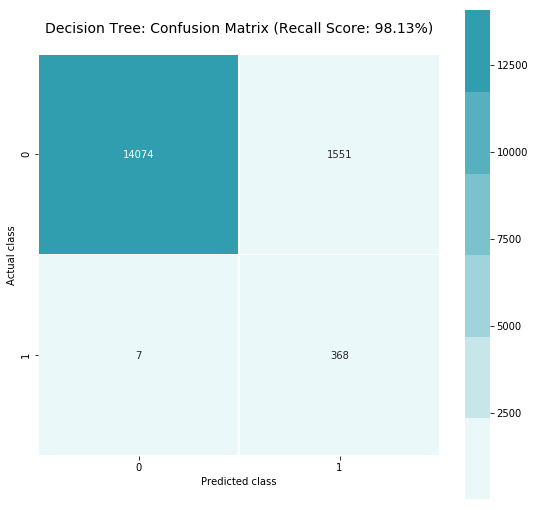

In [63]:
y_pred = tree.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'Decision Tree: Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

### Visualizing the tree (requires graphviz)

#### If !dot is not recognized as a valid command, converting .dot to .png online is possible using https://dreampuf.github.io/GraphvizOnline/

In [46]:
export_graphviz(tree, feature_names=df_train.columns[1:], out_file='./files/aps_tree.dot', filled=True)
!dot -Tpng './files/aps_tree.dot' -o './files/aps_tree.png'

'dot' is not recognized as an internal or external command,
operable program or batch file.


### How the tree looks like (if it does not show up in the notebook, see files/aps_tree.png)

<img src="files/aps_tree.png">

## 3.3. Random Forest

### Baseline

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
rfc = RandomForestClassifier(random_state=20, n_jobs=-1, oob_score=True, bootstrap=True)
results = cross_val_score(rfc, X_train, y_train, cv=skf, scoring='recall')
print("CV recall score: {:.2f}%".format(results.mean()*100))

CV recall score: 62.90%


### Choosing the best parameters. Tuned parameters: n_estimators - number of trees,

In [30]:
parameters = {'n_estimators': [100, 150, 200], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 3, 5], 'max_depth': [20, 25, 30], 'class_weight': [None, 'balanced']}
rfc = RandomForestClassifier(n_estimators=100, random_state=20, n_jobs=-1, oob_score=True, bootstrap=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=10, scoring='recall')
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 57.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 61.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 67.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 76.2min
[Paralle

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=20, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 3, 5], 'max_depth': [20, 25, 30], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=10)

### The best parameters are:

In [32]:
gcv.best_params_

{'class_weight': 'balanced',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'n_estimators': 100}

### Applying the model to the test set, measuring recall, printing confusion matrix and total costs

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
rfc = RandomForestClassifier(n_estimators=200, random_state=20, n_jobs=-1, oob_score=True, max_depth=20, max_features='log2', min_samples_leaf=5, class_weight='balanced', bootstrap=True)
results = cross_val_score(rfc, X_train, y_train, cv=skf, scoring='recall')
print("CV recall score: {:.2f}%".format(results.mean()*100))

CV recall score: 81.20%


In [37]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=20,
            verbose=0, warm_start=False)

Recall Score: 84.27%
Total Costs:  30530


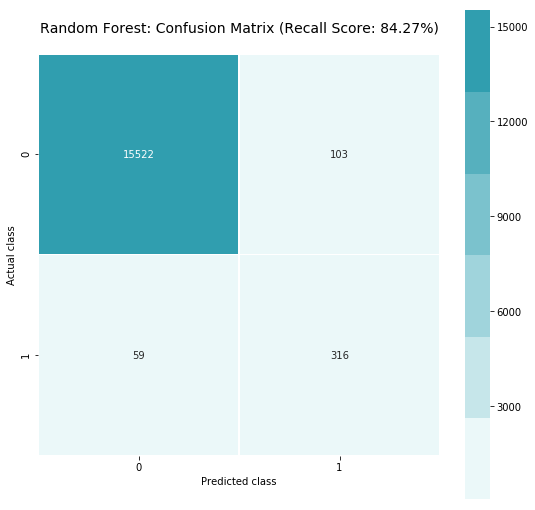

In [39]:
y_pred = rfc.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'Random Forest: Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

## 3.4. SVM

### Baseline

In [69]:
clf = svm.SVC(random_state=20, kernel='rbf', C=10, gamma=0.001)
clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=20, shrinking=True,
  tol=0.001, verbose=False)

Recall Score: 65.60%
Total Costs:  64750


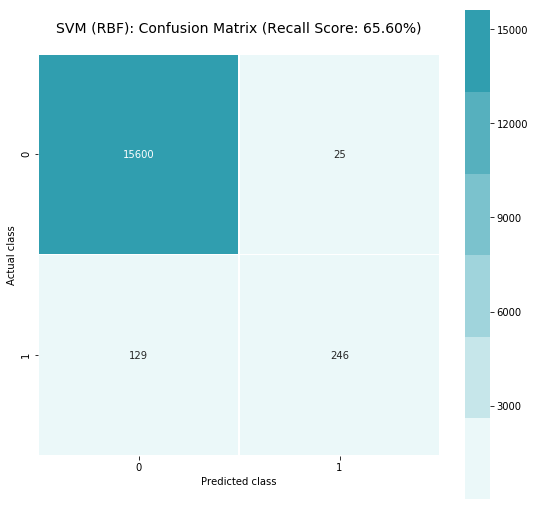

In [71]:
y_pred = clf.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'SVM (RBF): Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

### Choosing best parameters for non-linear kernel. Tuned parameters: kernel - radial-based function, sigmoid and polynomial, gamma and C.

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, \
              {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, \
              {'kernel': ['poly'], 'gamma': [1e-3, 1e-4], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

clf = svm.SVC(random_state=20)
gcv = GridSearchCV(clf, parameters, n_jobs=-1, cv=skf, verbose=10, scoring='recall')
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 32.8min
[Paralle

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=20, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'kernel': ['poly'], 'gamma': [0.001, 0.0001], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=10)

### The best parameters are:

In [41]:
gcv.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'poly'}

### Applying the model to the test set, measuring recall, printing the confusion matrix and total costs

In [72]:
clf = svm.SVC(random_state=20, kernel='poly', C=1000, gamma=0.001)
clf.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
  max_iter=-1, probability=False, random_state=20, shrinking=True,
  tol=0.001, verbose=False)

Recall Score: 74.93%
Total Costs:  47500


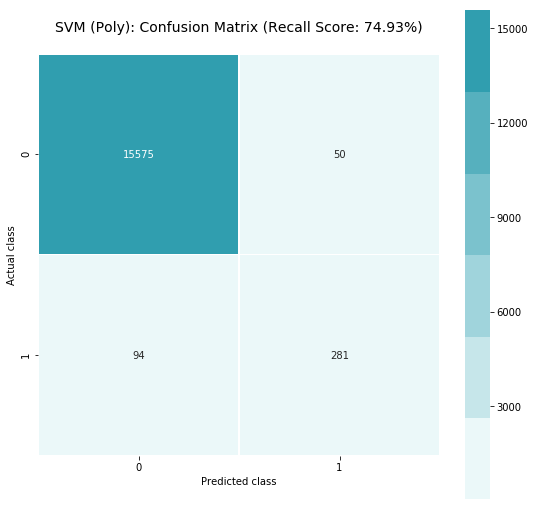

In [73]:
y_pred = clf.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'SVM (Poly): Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

### Trying linear kernel (using Stochastic Gradient Descent classifier with hinge loss)

### Baseline

In [84]:
clf = SGDClassifier(random_state=20, n_jobs=-1, alpha=1, loss='hinge', class_weight='balanced')   
clf.fit(X_train, y_train)

SGDClassifier(alpha=1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=20, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Recall Score: 94.67%
Total Costs:  15410


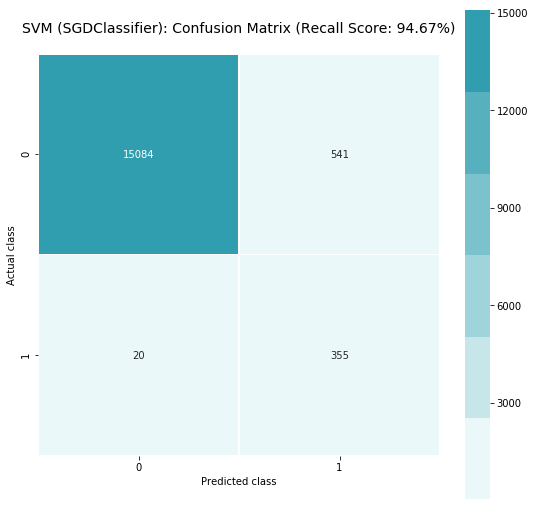

In [85]:
y_pred = clf.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'SVM (SGDClassifier): Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

In [54]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
parameters = [{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
clf = SGDClassifier(random_state=20)
gcv = GridSearchCV(clf, parameters, n_jobs=-1, cv=skf, verbose=10, scoring='recall')
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    7.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=20, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=10)

In [55]:
gcv.best_params_

{'alpha': 0.0001}

In [81]:
clf = SGDClassifier(random_state=20, n_jobs=-1, loss='hinge', class_weight='balanced', alpha=0.0001)   
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=20, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Recall Score: 96.80%
Total Costs:  13140


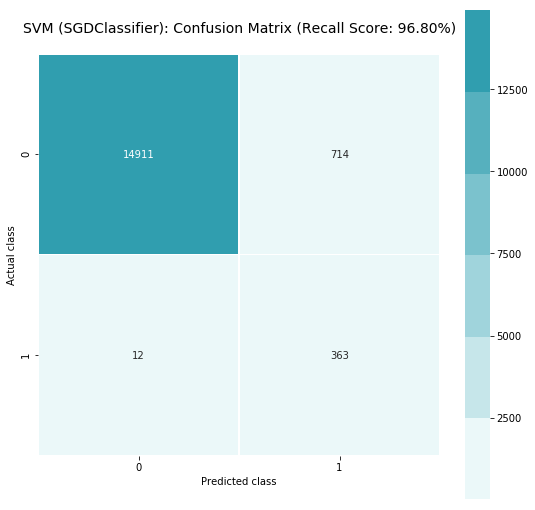

In [82]:
y_pred = clf.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'SVM (SGDClassifier): Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

### Trying linear kernel (using LinearSVC implementation) - just for fun and to check whether SGDClassifier and LinearSVC produce the same result or not

In [86]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
parameters = [{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

clf = svm.LinearSVC(random_state=20, class_weight='balanced')
gcv = GridSearchCV(clf, parameters, n_jobs=-1, cv=skf, verbose=10, scoring='recall')
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  7.3min remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=20, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=10)

In [90]:
gcv.best_params_

{'C': 0.0001}

In [91]:
clf = svm.LinearSVC(random_state=20, class_weight='balanced', C=0.0001)   
clf.fit(X_train, y_train)

LinearSVC(C=0.0001, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=20, tol=0.0001,
     verbose=0)

Recall Score: 94.93%
Total Costs:  13520


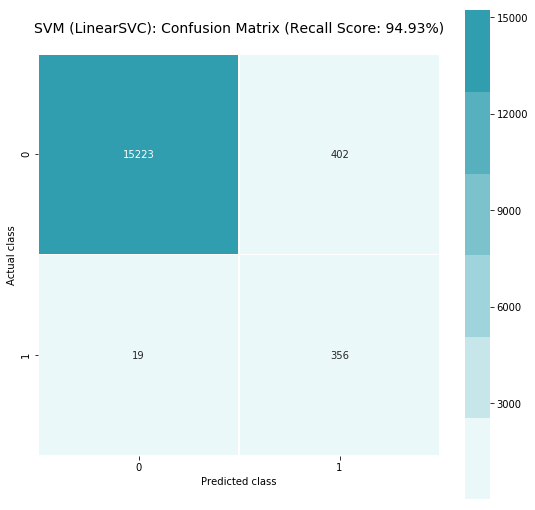

In [92]:
y_pred = clf.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'SVM (LinearSVC): Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);

## 3.5 LightGBM

In [25]:
print('Start training...')
# train
gbm = lgb.LGBMClassifier(objective='binary',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=5)

print('Start predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

# other scikit-learn modules
estimator = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', is_unbalance=True, random_state=20, n_jobs=-1)

param_grid = {'learning_rate': [0.001, 0.005, 0.01, 0.1, 1], 
              'n_estimators': [20, 50, 100, 200], 
              'num_leaves': [10, 15, 20, 31]
             }

gbm = GridSearchCV(estimator, param_grid, scoring='recall')

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Start training...
[1]	valid_0's l2: 0.22635
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.205073
[3]	valid_0's l2: 0.185899
[4]	valid_0's l2: 0.168599
[5]	valid_0's l2: 0.152995
[6]	valid_0's l2: 0.138937
[7]	valid_0's l2: 0.126257
[8]	valid_0's l2: 0.11481
[9]	valid_0's l2: 0.104451
[10]	valid_0's l2: 0.0951102
[11]	valid_0's l2: 0.086697
[12]	valid_0's l2: 0.0790678
[13]	valid_0's l2: 0.0721715
[14]	valid_0's l2: 0.0659369
[15]	valid_0's l2: 0.0602839
[16]	valid_0's l2: 0.0551677
[17]	valid_0's l2: 0.050569
[18]	valid_0's l2: 0.0464124
[19]	valid_0's l2: 0.0426295
[20]	valid_0's l2: 0.0391985
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.0391985
Start predicting...
The rmse of prediction is: 0.09842509842514764
Feature importances: [14, 0, 2, 0, 0, 0, 0, 30, 27, 5, 5, 1, 0, 0, 2, 0, 3, 11, 9, 0, 51, 20, 1, 2, 0, 8, 0, 0, 1, 0, 0, 0, 15, 0, 8, 4, 0, 41, 25, 9, 21, 5, 2, 0, 4, 5, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 3, 0

In [26]:
gbm.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        is_unbalance=True, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=20, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.1, 1], 'n_estimators': [20, 50, 100, 200], 'num_leaves': [10, 15, 20, 31]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

Recall Score: 97.60%
Total Costs:  12880


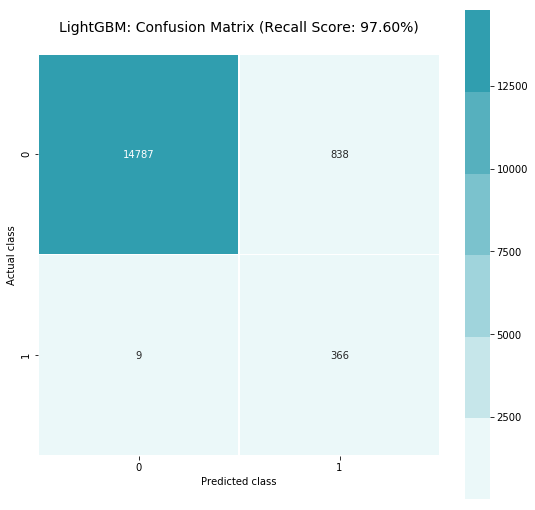

In [27]:
y_pred = gbm.predict(X_test)
Recall = recall_score(y_test, y_pred)
print('Recall Score: {:.2f}%'.format(Recall*100))
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Total Costs: ', cm[0][1]*10+cm[1][0]*500)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.light_palette((210, 90, 60), input="husl"));
plt.ylabel('Actual class');
plt.xlabel('Predicted class');
all_sample_title = 'LightGBM: Confusion Matrix (Recall Score: {:.2f}%)\n'.format(Recall*100)
plt.title(all_sample_title, size = 14);